## A/B testing of the new visual content of the Bakery
 👨🏻‍🍳🥨🥐🥖


The project involves A/B testing of new visual content, which includes adding product production videos and extra images. 
The main goal of the project is to increase order conversion by improving the visual presentation of products on the website pages.

*1. `Business problem:`* it is assumed that conversions from visit to purchase in our bakery are not high enough.
Having studied competitors' pages and it is clear that there is an opportunity to increase sales by slightly redesigning the product catalogue page. 

*2. `Hypothesis:`* adding a video of the process of making goodies is supposed to motivate customers to buy them and achieve two effects:
   * an increase in conversion from visit to payment (more clients will want to buy our products)
   * at a minimum, no decrease in the average purchase value, and ideally, an increase in the average purchase value
    
*3. `Expected actions of clients:`* it is expected that by seeing a video of the process of making the goodies along with a description of the products, more potential customers will want to make a purchase, and possibly - on average - buy more products in one order.

*4. `The experiment will be assumed succsesfull, if:`*
   * conversition from visit to purchase with a window of 7 days will increase 
   * the average purchase value will not decrease


## What needs to be done?

Analyse the data from the new test and make an assumption about its success. Can the change be deployed to all users?

1. Select a conversion window.
2. Analyse the distribution of users into groups by main segments.
3. Evaluate statistical significance in the conversion change using the chi-square criterion.
4. Calculate the power of the test.
5. Use bootstrap to evaluate the effect of the test on the average cheque.
6. Draw a conclusion from the results of the test.

In [3]:
import pandas as pd
import numpy as np

In [4]:
historical_data = pd.read_csv('investigate_window.csv')

In [5]:
historical_data.head()

,Unnamed: 0,user_id,main_page_viewed_at,order_completed_at,time_to_order
0,0,959238,2020-11-20 23:55:02.759000+00:00,2020-11-30 02:22:32.759000+00:00,9.102431
1,1,337366,2020-12-05 23:41:42.244000+00:00,2020-12-12 22:25:52.244000+00:00,6.947338
2,2,259956,2020-11-20 23:33:53.269000+00:00,2020-11-25 13:08:03.269000+00:00,4.565394
3,3,534280,2020-11-28 23:44:56.556000+00:00,2020-12-05 10:14:06.556000+00:00,6.436921
4,4,795121,2020-11-18 23:59:56.236000+00:00,2020-11-27 02:38:16.236000+00:00,8.109954


In [6]:
historical_data = pd.read_csv('investigate_window.csv', parse_dates = [2,3], index_col = 0)
historical_data.dtypes

user_id                              int64
main_page_viewed_at    datetime64[ns, UTC]
order_completed_at     datetime64[ns, UTC]
time_to_order                      float64
dtype: object

## 1. Calculate the 95, 90 and 85 percentiles for our data using the column time_to_order.

In [7]:
import numpy as np

In [8]:
import seaborn as sns 
import matplotlib.pyplot as plt

In [9]:
perc_95 = np.percentile(historical_data['time_to_order'], 95) 
perc_95

7.117476851851854

In [10]:
perc_90 = np.percentile(historical_data['time_to_order'], 90)
perc_90

2.864949845679016

In [11]:
perc_85 = np.percentile(historical_data['time_to_order'], 85)
perc_85

1.9903886959876524

## 2. The building a histogram of the distribution of time between the first visit to the site and purchase

In [12]:
perc_85 = round(np.percentile(historical_data['time_to_order'], 85), 1)

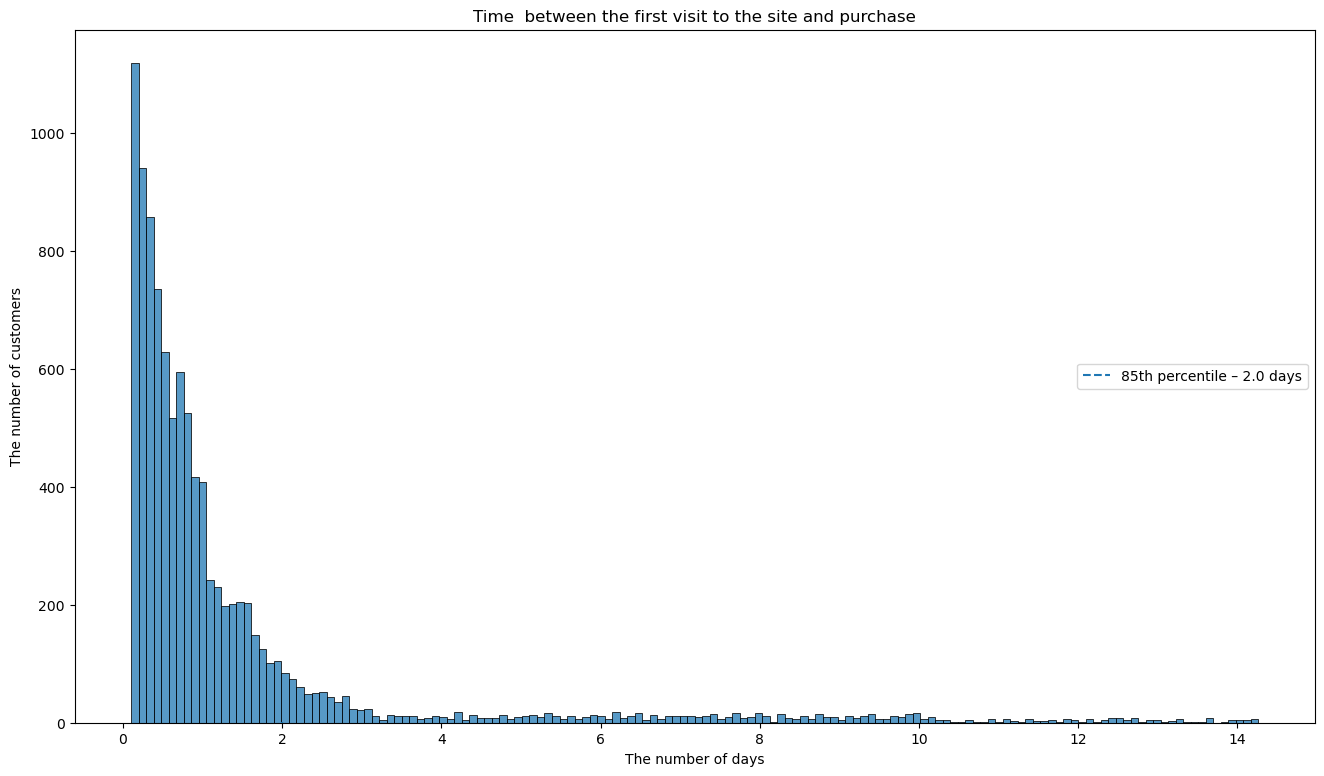

In [13]:
plt.figure(figsize=(16,9))
sns.histplot(historical_data['time_to_order'])
plt.vlines(perc_85, ymin = 0, ymax = 0.7, linestyles = 'dashed', label = f'85th percentile – {perc_85} days')
plt.title('Time  between the first visit to the site and purchase')
plt.xlabel('The number of days')
plt.ylabel('The number of customers')
plt.legend(loc='center right')
plt.show()

### Research the distribution of users into groups by major segments

In [14]:
import pandas as pd
import numpy as np

bakery_data = pd.read_csv('bakery_ab_test.csv', index_col=0)
bakery_data

,user_id,test_group,purchase_amount,geo_group,acquisition_channel,within_window,platform
1,3738,test,306.639511,regions,target_direct,1,pc
2,3755,control,NaN,regions,target_direct,0,pc
3,3772,test,NaN,regions,context_brand,0,mobile
4,3789,control,NaN,spb,target_direct,0,pc
5,3806,test,NaN,regions,social_media,0,pc
...,...,...,...,...,...,...,...
152995,2604636,test,NaN,regions,target_direct,0,pc
152996,2604653,control,5236.818309,regions,organic,1,mobile
152997,2604670,control,NaN,regions,target_direct,0,pc
152998,2604687,control,101.783032,regions,target_direct,1,pc


In [15]:
group_cnt = bakery_data['test_group'].value_counts()
channel_cnt = bakery_data['acquisition_channel'].value_counts()

print(group_cnt)
print(channel_cnt)

test       75273
control    75210
Name: test_group, dtype: int64
target_direct    71365
organic          45394
social_media     19385
context_brand    14339
Name: acquisition_channel, dtype: int64


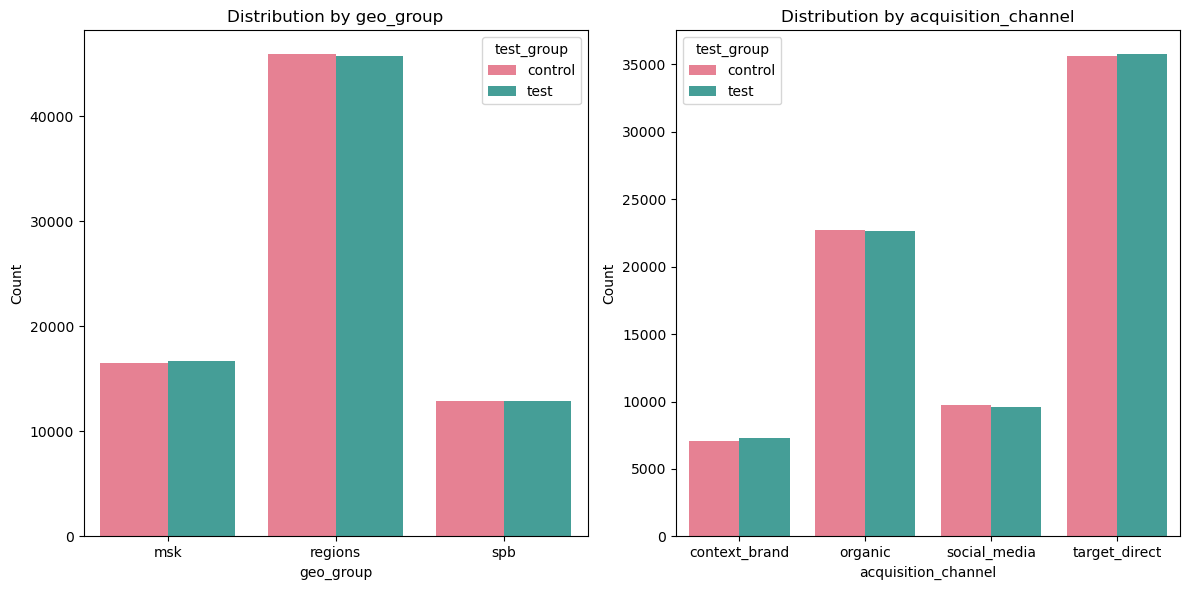

In [19]:
# A function "plot_segment_distribution" uses to check the distribution of users across segments within each group and 
# aggregates the data for each segment in the function, counting the number of users for each group and segment.

import seaborn as sns
import matplotlib.pyplot as plt

def plot_segment_distribution(bakery_data, segment_columns, test_factor):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    for i, segment in enumerate(segment_columns):
        aggregated_data = bakery_data.groupby(by=[test_factor, segment])['user_id'].count().reset_index()
        sns.barplot(x=segment, 
                    y='user_id', 
                    hue=test_factor, 
                    data=aggregated_data, 
                    ax=axs[i],
                    palette='husl')
        axs[i].set_title(f'Distribution by {segment}')
        axs[i].set_xlabel(segment)
        axs[i].set_ylabel('Count')
    plt.tight_layout()
    plt.show()

    
plot_segment_distribution(bakery_data, ['geo_group', 'acquisition_channel'], 
                                        'test_group')
     
        

#### The graph shows that the number of users in the control and test groups within each segment: "geo_group" and "acquisition_channel" is approximately the same, which indicates a good split quality and even distribution of data between the control and test groups, which makes the comparison of A/B testing results more objective and reliable.

## 3. Assessment of statistical significance of differences between control and test groups

In [20]:
# To assess the statistical significance of differences between the control and test groups on the categorical variable - conversion, 
# I use the Chi-square criterion.

# The total numbers of customers
users_cnt = bakery_data.groupby('test_group').size().reset_index(name='users_cnt')

# Number of purchases in the conversion window 
conver_cnt = bakery_data.loc[bakery_data['within_window']==1].groupby('test_group')['user_id'].nunique().reset_index(name='conver_cnt')

# Average amount of purchase
mean_purchase_value = bakery_data.groupby('test_group')['purchase_amount'].mean().reset_index(name='mean_purchase_value')

# Conversion 
metrics = bakery_data.groupby('test_group')['within_window'].mean().reset_index(name='conversion')
metrics = bakery_data.groupby('test_group', as_index= 0).agg({'user_id': 'count', 'within_window': 'sum'})
metrics['conversion'] = round(metrics['within_window']/metrics['user_id']*100, 2)
metrics

,test_group,user_id,within_window,conversion
0,control,75210,22998,30.58
1,test,75273,24427,32.45


In [21]:

pc_users = bakery_data.loc[bakery_data['platform'] == 'pc']

# The total numbers of customers from platform = 'pc'
users_cnt_pc = pc_users.groupby('test_group').size().reset_index(name='users_cnt')

# Number of purchases in the conversion window users of the 'pc' platform
conver_cnt_pc = pc_users.loc[pc_users['within_window'] == 1].groupby('test_group')['user_id'].nunique().reset_index(name='conver_cnt')

# Average amount of purchase users of the 'pc' platform
mean_purchase_value_pc = pc_users.groupby('test_group')['purchase_amount'].mean().reset_index(name='mean_purchase_value')

# Conversion from 'pc' platform
metrics_pc = pc_users.groupby('test_group')['within_window'].mean().reset_index(name='conversion')
metrics_pc = pc_users.groupby('test_group', as_index=0).agg({'user_id': 'count', 'within_window': 'sum'})
metrics_pc['conversion'] = round(metrics_pc['within_window'] / metrics_pc['user_id'] * 100, 2)
metrics_pc


,test_group,user_id,within_window,conversion
0,control,45112,13732,30.44
1,test,60317,19659,32.59


In [22]:

mobile_users = bakery_data.loc[bakery_data['platform'] == 'mobile']

# The total numbers of customers from platform = 'mobile'
users_cnt_mobile = mobile_users.groupby('test_group').size().reset_index(name='users_cnt')

# Number of purchases in the conversion window users of the 'mobile' platform
conver_cnt_mobile = mobile_users.loc[mobile_users['within_window'] == 1].groupby('test_group')['user_id'].nunique().reset_index(name='conver_cnt')

# Average amount of purchase users of the 'mobile' platform
mean_purchase_value_mobile = mobile_users.groupby('test_group')['purchase_amount'].mean().reset_index(name='mean_purchase_value')

# Conversion from 'mobile' platform
metrics_mobile = mobile_users.groupby('test_group')['within_window'].mean().reset_index(name='conversion')
metrics_mobile = mobile_users.groupby('test_group', as_index=0).agg({'user_id': 'count', 'within_window': 'sum'})
metrics_mobile['conversion'] = round(metrics_mobile['within_window'] / metrics_mobile['user_id'] * 100, 2)
metrics_mobile


,test_group,user_id,within_window,conversion
0,control,30098,9266,30.79
1,test,14956,4768,31.88


## 4. Chi-square test for calculating p-value

In [23]:
import statsmodels.stats.proportion as proportion

In [24]:
chi2stat, pval, table = proportion.proportions_chisquare(metrics['conversion'], metrics['user_id'])

In [25]:
print('hi2stat = ',chi2stat)
print('pval = ',pval)
print('table = ',table)

hi2stat =  0.05394782473474283
pval =  0.8163308667537793
table =  (array([[3.058000e+01, 7.517942e+04],
       [3.245000e+01, 7.524055e+04]]), array([[3.15018062e+01, 7.51784982e+04],
       [3.15281938e+01, 7.52414718e+04]]))


In [26]:
chi2stat_pc, pval_pc, table_pc = proportion.proportions_chisquare(metrics_pc['conversion'], metrics_pc['user_id'])
print('chi2stat_pc = ',chi2stat_pc)
print('pval_pc =',pval_pc)
print('table_pc = ',table_pc)

chi2stat_pc =  0.780881781090049
pval_pc = 0.3768715954060702
table_pc =  (array([[3.044000e+01, 4.508156e+04],
       [3.259000e+01, 6.028441e+04]]), array([[2.69698978e+01, 4.50850301e+04],
       [3.60601022e+01, 6.02809399e+04]]))


In [27]:
chi2stat_mobile, pval_mobile, table_mobile = proportion.proportions_chisquare(metrics_mobile['conversion'], metrics_mobile['user_id'])
print('chi2stat_mobile = ',chi2stat_mobile)
print('pval_mobile =',pval_mobile)
print('table_mobile = ',table_mobile)

chi2stat_mobile =  8.839817579905878
pval_mobile = 0.0029472860301175247
table_mobile =  (array([[   30.79, 30067.21],
       [   31.88, 14924.12]]), array([[4.18662418e+01, 3.00561338e+04],
       [2.08037582e+01, 1.49351962e+04]]))


In [28]:

# alpha is pre-determined significance level 

alpha = 0.05 

In [29]:
if pval < alpha: 
    print('The result of the experiment can be considered statistically significant')
elif pval > alpha: 
    print('No statistically significant difference in conversion was found as the p-value is above the selected threshold of first-order  error')

No statistically significant difference in conversion was found as the p-value is above the selected threshold of first-order  error


#### CONCLUSION: Since NO statistical significance was found between the conversions and the p-value exceeds the chosen threshold of first-order error, it is not possible to reject the null hypothesis that there is no statistically significant difference between the groups. In this case, the null hypothesis of equality of mean conversions is accepted.

## 5.Calculating the power of the Test

In [30]:
import statsmodels.stats.power as smp


In [31]:
chipower = smp.GofChisquarePower()


`effect_size` — is the observed difference between the two options. It is calculated as follows: 

$$ES = \sqrt{(p_0 - p_1)^2/p_o}$$

, where $p_0$ is conversion in control group and $p_1$ — conversion in test group

In [32]:
def chi2_effect_size(p0, p1):
    return np.sqrt(((p0 - p1)**2 / p0))

In [33]:
# conversion in the control group
conversion_control = metrics['conversion'].values[0]/100 

# conversion in the test group 
conversion_test = metrics['conversion'].values[1]/100

nobs = min(metrics['user_id'])


In [34]:
# conversion in the control group of users from platform = 'mobile'
conversion_control_mobile = metrics_mobile['conversion'].values[0]/100

#conversion in the test group of users from platform = 'mobile'
conversion_test_mobile = metrics_mobile['conversion'].values[1]/100

nobs_mobile =  min(metrics_mobile['user_id'])


In [35]:
# conversion in the control group of users from platform = 'PC'
conversion_control_pc = metrics_pc['conversion'].values[0]/100

# conversion in the test group of users from platform = 'PC'
conversion_test_pc = metrics_pc['conversion'].values[1]/100

nobs_pc = min(metrics_pc['user_id'])


In [36]:
power = chipower.solve_power(effect_size = chi2_effect_size(conversion_control, conversion_test), 
                                                           nobs = nobs,
                                                           alpha = pval, 
                                                           power = None) 
power

1.0

In [37]:
mobile_power = chipower.solve_power(effect_size = chi2_effect_size(conversion_control_mobile, conversion_test_mobile), 
                                                           nobs = nobs_mobile,
                                                           alpha = pval_mobile, 
                                                           power = None)
mobile_power

0.2840435046099488

In [38]:
pc_power = chipower.solve_power(effect_size = chi2_effect_size(conversion_control_pc, conversion_test_pc), 
                                                           nobs = nobs_pc,
                                                           alpha = pval_pc, 
                                                           power = None)
pc_power

0.9999999999999282

#### For the "mobile" segment, the power is 0.284, meaning that the test is not very sensitive to detect real differences between the test and control groups in this segment. For the "PC" segment and total users, power values close to 1 are obtained, indicating that the test is sufficiently sensitive in these segments. However, due to the low power for one of the segments, it is not possible to draw a reliable conclusion based on this test as a whole.

## 6. Estimation of confidence intervals and indicators of statistical significance for the average cheque using bootstrapped 

In [39]:
import bootstrapped

In [40]:
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare
import numpy as np

In [41]:
## Calculating the avarage check in the control and the test groups for all users
test = bakery_data[(bakery_data['test_group'] == 'test')]['purchase_amount'].dropna().values
control = bakery_data[(bakery_data['test_group'] == 'control')]['purchase_amount'].dropna().values

## Calculating the avarage check in the control and the test groups for users from platform = 'PC'
test_pc = bakery_data[(bakery_data['test_group'] == 'test') & (bakery_data['platform'] == 'pc')]['purchase_amount'].dropna().values
control_pc = bakery_data[(bakery_data['test_group'] == 'control') & (bakery_data['platform'] == 'pc')]['purchase_amount'].dropna().values

## Calculating the avarage check in the control and the test groups for users from platform = 'mobile'
test_mobile = bakery_data[(bakery_data['test_group'] == 'test') & (bakery_data['platform'] == 'mobile')]['purchase_amount'].dropna().values
control_mobile = bakery_data[(bakery_data['test_group'] == 'control') & (bakery_data['platform'] == 'mobile')]['purchase_amount'].dropna().values



In [42]:
boot = bs.bootstrap_ab(test = test
                            , ctrl = control
                            , stat_func = bs_stats.mean
                            , compare_func = bs_compare.difference
                            , return_distribution=True)

In [43]:
boot_pc = bs.bootstrap_ab(test = test_pc
                               , ctrl = control_pc
                               , stat_func = bs_stats.mean
                               , compare_func = bs_compare.difference
                               , return_distribution=True)

In [44]:
boot_mobile = bs.bootstrap_ab(test = test_mobile
                                   , ctrl = control_mobile
                                   , stat_func = bs_stats.mean
                                   , compare_func = bs_compare.difference
                                   , return_distribution=True)

### Have been used percentiles (specifically 2.5% and 97.5%) to define the limits of the 95-% confidence interval range

In [45]:
borders = np.percentile(boot, [2.5, 97.5]) 

borders_pc = np.percentile(boot_pc, [2.5, 97.5])  

borders_mobile = np.percentile(boot_mobile, [2.5, 97.5])


## 7. The building of a histogram of the distribution of values of the average cheque, with the boundaries of the confidence interval marked, and the zero level

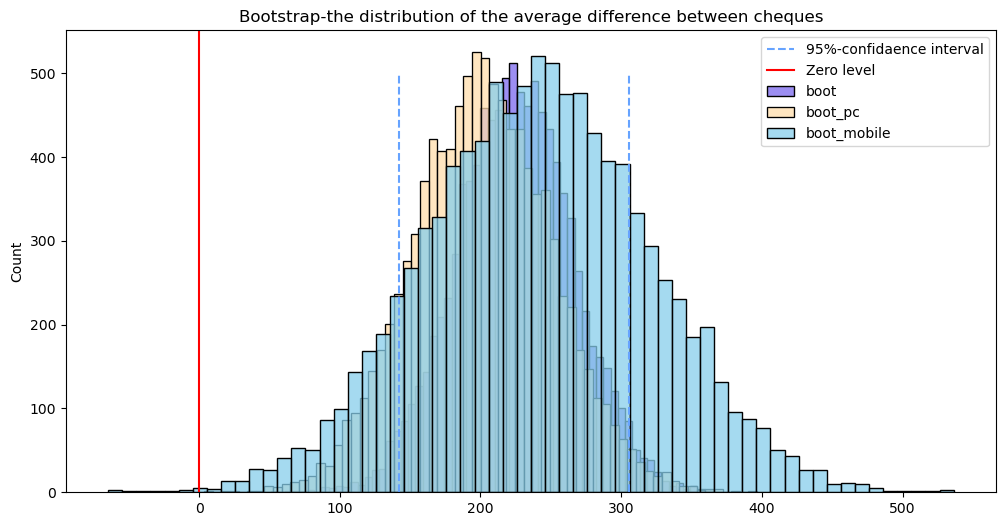

In [47]:
# 
sns.histplot(boot, label='boot', color='#7B68EE')
sns.histplot(boot_pc, label='boot_pc', color='#FFDEAD')
sns.histplot(boot_mobile, label='boot_mobile', color='#87CEEB')

plt.title('Bootstrap-the distribution of the average difference between cheques')
plt.rcParams["figure.figsize"] = (20, 6)
plt.vlines(0,  
           ymin=0,
           ymax=0.003,
           linestyles='--',
           colors='#E60000')
plt.vlines(borders,  
           ymin=0,
           ymax=500,
           linestyles='--',
           colors='#66A3FF',
           label='95%-confidaence interval')

plt.axvline(0, color='#FF0000', linewidth=1.5, label='Zero level')
plt.legend()

plt.show()

## CONCLUSION
### According to the results of the A/B test run to compare the change in the average cheque of the two groups in each segment, a statistically significant result was found. Namely, the confidence interval for the difference in mean values does not contain zero, which indicates that the groups do differ in terms of average check. This means that the differences found between the groups cannot be explained by mere random factors and represent real differences in consumer behaviour or the effectiveness of the strategies employed in each group. Thus, it is safe to say that the A/B test conducted has produced important and valid results that confirm the statistical significance of the differences between the groups.